In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pygtc
import batman
import scipy

In [9]:
def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    chi2_tess = []
    sum_ln_sigma_tess = []

    for i in range(0, 4):
        m_tess = batman.TransitModel(params, bjd_tess[i])
        tess_model = m_tess.light_curve(params)
        tess_errors_with_jitter = flux_error_tess[i]**2 + theta[12]**2
        chi2_tess = np.append(np.sum((flux_tess[i]-tess_model)**2 / tess_errors_with_jitter), chi2_tess)
        sum_ln_sigma_tess = np.append(np.sum(np.log(tess_errors_with_jitter)), sum_ln_sigma_tess)

    params.u = [theta[7] , theta[8]]

    median_bjd = np.median(bjd_taste)
    polynomial_trend = theta[9]+theta[10]*(bjd_taste-median_bjd) + theta[11]*(bjd_taste-median_bjd)**2
    
    m_taste = batman.TransitModel(params, bjd_taste)
    taste_flux = m_taste.light_curve(params) * polynomial_trend

    taste_errors_with_jitter = flux_error_taste**2 + theta[13]**2

    N = len(tess_errors_with_jitter) + len(taste_errors_with_jitter)

    chi2_taste = np.sum((flux_taste-taste_flux)**2 / taste_errors_with_jitter)

    sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess[0] + chi2_tess[1] + chi2_tess[2] + chi2_tess[3] + chi2_taste + 
                             sum_ln_sigma_tess[0] + sum_ln_sigma_tess[1] + sum_ln_sigma_tess[2] + sum_ln_sigma_tess[3] + sum_ln_sigma_taste)
    return log_likelihood

def log_prior(theta):
    prior = 0.00
    prior+= np.log(scipy.stats.norm.pdf(theta[5], loc=0.5011, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[6], loc=0.1396, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[7], loc=0.6367, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[8], loc=0.1300, scale=0.10))
    return prior

def log_posterior(theta):

    boundaries = np.empty([2, len(theta)])

    boundaries[:,0] = [theta[0]-0.5, theta[0]+0.5]
    boundaries[:,1] = [theta[1]-0.5, theta[1]+0.5]
    boundaries[:,2] = [0.0, 0.5]
    boundaries[:,3] = [0.0, 20.]
    boundaries[:,4] = [80.0, 90.0]
    boundaries[:,5] = [0.00, 1.0]
    boundaries[:,6] = [0.00, 1.0]
    boundaries[:,7] = [0.00, 1.0]
    boundaries[:,8] = [0.00, 1.0]
    boundaries[:,9] = [0.0, 1.0]
    boundaries[:,10] = [-1.0, 1.0]
    boundaries[:,11] = [-1.0, 1.0]
    boundaries[:,12] = [0.0, 0.05]
    boundaries[:,13] = [0.0, 0.05]
    
    sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
    if np.sum(sel) > 0:
        return -np.inf
    
    log_post = log_prior(theta)

    log_post += log_likelihood(theta)
    return log_post

In [10]:
#import the results of MCMCs

taste = pickle.load(open('../Results/MCMC/TASTE/run_taste_v5.p', 'rb'))

tess_all = pickle.load(open('../Results/MCMC/TESS/run_alltess_v2.p', 'rb'))

tess_s23 = pickle.load(open('../Results/MCMC/TESS/run23_tess_v4.p', 'rb'))
tess_s49 = pickle.load(open('../Results/MCMC/TESS/run49_tess_v4.p', 'rb'))
tess_s50 = pickle.load(open('../Results/MCMC/TESS/run50_tess_v4.p', 'rb'))
tess_s76 = pickle.load(open('../Results/MCMC/TESS/run76_tess_v4.p', 'rb'))

taste_tess = pickle.load(open('../Results/MCMC/taste_tess(t)_v2.p', 'rb'))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

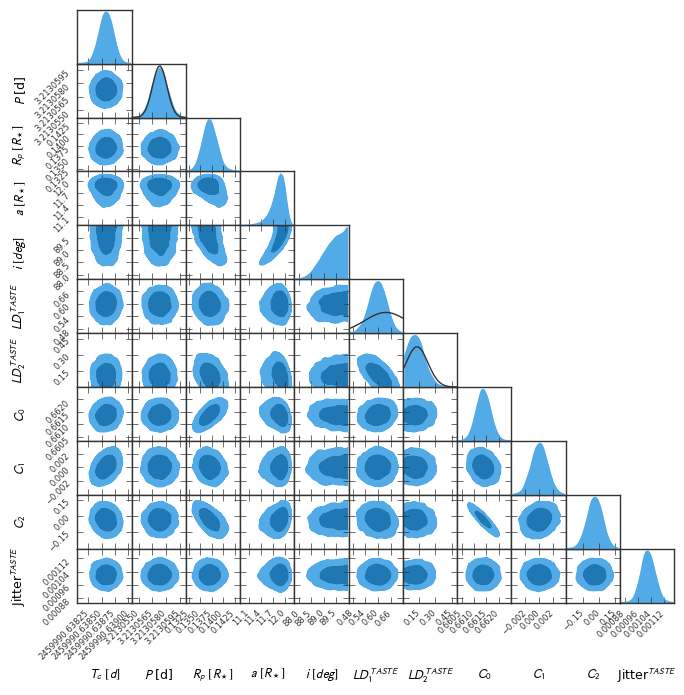

In [11]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$LD_1^{TASTE}$',
         '$LD_2^{TASTE}$',
         '$C_0$',
         '$C_1$',
         '$C_2$',
         'Jitter$^{TASTE}$')

priors = (None, (3.2130573, 0.0000008),
          None, None, None,
          (0.6367, 0.1),
          (0.1300, 0.1), 
          None, None, None, None)
flat_sample_taste = taste.get_chain(discard=5000, thin=100, flat=True)
GTC = pygtc.plotGTC(chains=flat_sample_taste, paramNames=paramnames, priors=priors, plotName = './Plots/mcmc_taste.png')

ndim = 11

from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_sample_taste[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

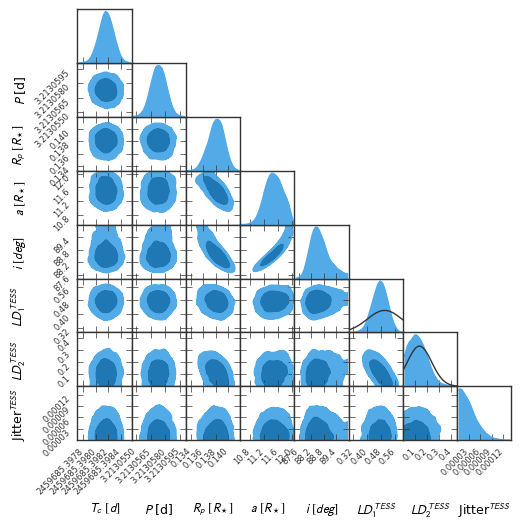

In [12]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$LD_1^{TESS}$',
         '$LD_2^{TESS}$',
         'Jitter$^{TESS}$')

priors = (None, None, None, None, None, 
          (0.5019, 0.1), (0.1364, 0.1), None)

flat_sample_tessall = tess_all.get_chain(discard=5000, thin=100, flat=True)
GTC = pygtc.plotGTC(chains=flat_sample_tessall, paramNames=paramnames, priors=priors, plotName='./Plots/mcmc_tessall.png')

ndim = 8

from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_sample_tessall[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

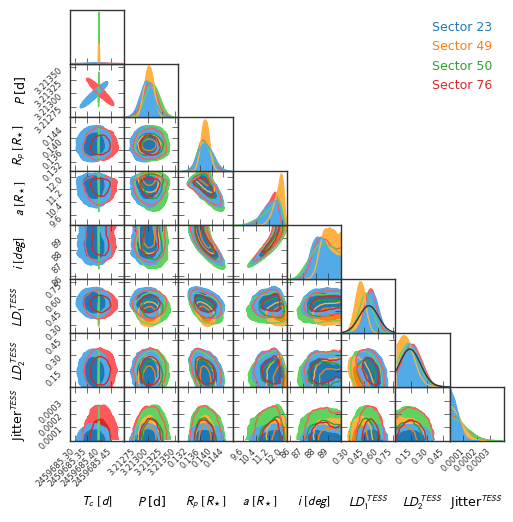

In [13]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$LD_1^{TESS}$',
         '$LD_2^{TESS}$',
         'Jitter$^{TESS}$')

flat_sample23 = tess_s23.get_chain(discard=5000, thin=100, flat=True)
flat_sample49 = tess_s49.get_chain(discard=5000, thin=100, flat=True)
flat_sample50 = tess_s50.get_chain(discard=5000, thin=100, flat=True)
flat_sample76 = tess_s76.get_chain(discard=5000, thin=100, flat=True)

flat_tess_individual = [flat_sample23, flat_sample49, flat_sample50, flat_sample76]

chainlabels = ('Sector 23', 'Sector 49', 'Sector 50', 'Sector 76')
priors = priors = (None, None, None, None, None, 
                   (0.5019, 0.1), (0.1364, 0.1), None)

GTC = pygtc.plotGTC(chains=[flat_sample23, flat_sample49, flat_sample50, flat_sample76], 
                    paramNames=paramnames, chainLabels=chainlabels, priors=priors, plotName='./Plots/mcmc_tessind.png')

ndim = 8

from IPython.display import display, Math
for j in range(4):
    flat_sample_tess = flat_tess_individual[j]
    for i in range(ndim):
        mcmc = np.percentile(flat_sample_tess[:, i], [15.865, 50, 84.135])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], i)
        display(Math(txt))
    print()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

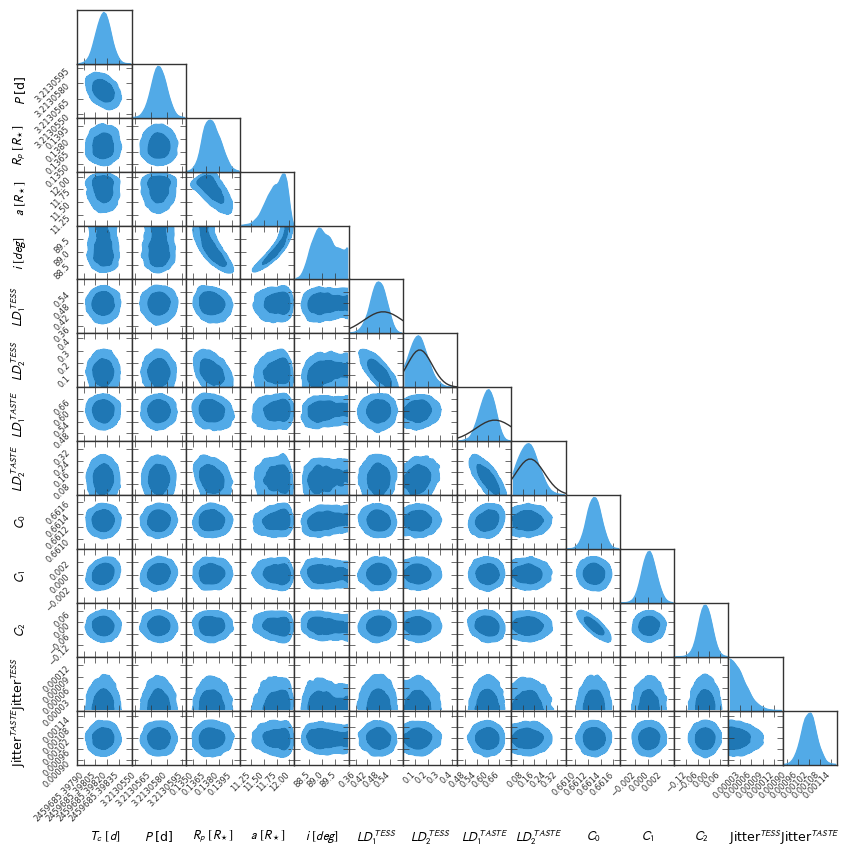

In [14]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$LD_1^{TESS}$',
         '$LD_2^{TESS}$',
         '$LD_1^{TASTE}$',
         '$LD_2^{TASTE}$',
         '$C_0$',
         '$C_1$',
         '$C_2$',
         'Jitter$^{TESS}$',
         'Jitter$^{TASTE}$')

priors = (None, None, None, None, None,
          (0.5019, 0.1),
          (0.1364, 0.1),
          (0.6367, 0.1),
          (0.1300, 0.1),
          None, None, None, None, None)

flat_sample_taste_tess = taste_tess.get_chain(discard=5000, thin=100, flat=True)
GTC = pygtc.plotGTC(chains=flat_sample_taste_tess, paramNames=paramnames, priors=priors, plotName='./Plots/mcmc_tastetess(t).png')

ndim = 14

for i in range(ndim):
    mcmc = np.percentile(flat_sample_taste_tess[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))